In [1]:
# Import statements
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Open data file
data = 'data.csv'
df = pd.read_csv(data)

In [3]:
# Process magnetic field strength data (split columns, format)
magnetic_field_data = df['Magnetic field strength']
magnetic_field_data = magnetic_field_data.str.split(',', expand=True)
magnetic_field_data.columns = ['x', 'y', 'z']
magnetic_field_data['x'] = magnetic_field_data['x'].map(lambda x: x.lstrip('x: '))
magnetic_field_data['y'] = magnetic_field_data['y'].map(lambda x: x.lstrip('y: '))
magnetic_field_data['z'] = magnetic_field_data['z'].map(lambda x: x.lstrip('z: '))

In [4]:
# Add and process sunlight data (format)
magnetic_field_data['Sunlight'] = df['Sunlight']
magnetic_field_data['Sunlight'] = magnetic_field_data['Sunlight'].map(lambda x: x.lstrip('In '))

We add a column where we store the magnitude of the magnetic field, obtained by taking the norm of the vector $(x, y, z)$. So, we take:
$$ \lVert  (x, y, z)  \rVert = \sqrt{x^2 + y^2 + z^2}. $$

In [5]:
magnetic_field_data[['x', 'y', 'z']] = magnetic_field_data[['x', 'y', 'z']].apply(pd.to_numeric)
magnetic_field_data['Magnitude'] = np.sqrt((magnetic_field_data['x'] ** 2) + (magnetic_field_data['y'] ** 2) + (magnetic_field_data['z'] ** 2))

In [6]:
# Add relative time column (from index, 15 seconds per measurement)
xticks = [i * 15 for i in range(len(magnetic_field_data['x']))]
magnetic_field_data['Time'] = xticks

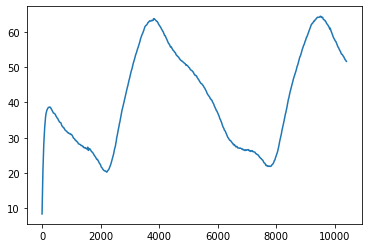

In [7]:
# Plot magnitude of magnetic field strength
magnitude_plot = plt.plot(magnetic_field_data['Time'], magnetic_field_data['Magnitude'])

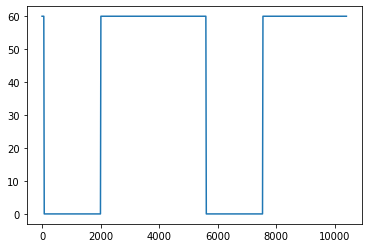

In [8]:
# Format and plot sunlight data
magnetic_field_data['Sunlight'].replace('sunlight', 60, inplace=True) # 60 for scale in combined plot (DEPRECATED)
magnetic_field_data['Sunlight'].replace('darkness', 0, inplace=True) # (DEPRECATED)
day_plot = plt.plot(magnetic_field_data['Time'], magnetic_field_data['Sunlight'])

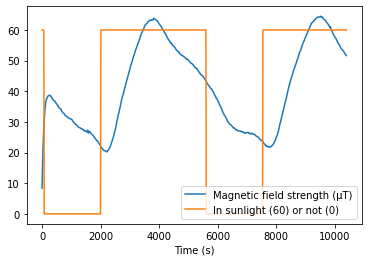

In [9]:
# Combined plot
plt.plot('Time', 'Magnitude', data=magnetic_field_data, label="Magnetic field strength (\u03BCT)")
plt.plot('Time', 'Sunlight', data=magnetic_field_data, label="In sunlight (60) or not (0)")
plt.xlabel("Time (s)")
plt.legend(loc='lower right')
plt.show()

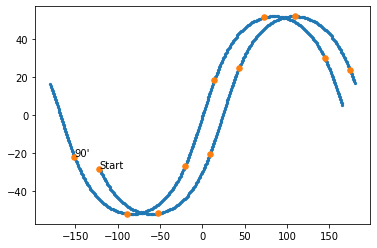

In [10]:
# Mapping the trajectory of the ISS
iss_data = df['Location']
iss_data = iss_data.str.split(' ', expand=True) # We'll remove some columns that are not needed for plotting
iss_data.drop(columns=iss_data[[0, 1, 3, 4, 6, 7, 8, 9]], axis=1, inplace=True)
iss_data.columns = ['Latitude', 'Longitude']
iss_data[['Latitude', 'Longitude']] = iss_data[['Latitude', 'Longitude']].apply(pd.to_numeric)

# We want to add a notion of time, by making a dot orange every 15 minutes (900) seconds
drop_for_orange = []
for i in range(0, len(iss_data['Latitude'])):
    if i % 60 != 0:
        drop_for_orange.append(i)
iss_data_orange = iss_data.drop(drop_for_orange)
iss_plot = plt.scatter(iss_data['Longitude'], iss_data['Latitude'], s = 5)
iss_plot = plt.scatter(iss_data_orange['Longitude'], iss_data_orange['Latitude'], s = 30, marker='o')
iss_plot = plt.annotate("Start", (iss_data_orange['Longitude'][0], iss_data_orange['Latitude'][0]))
iss_plot = plt.annotate("90'", (iss_data_orange['Longitude'][360], iss_data_orange['Latitude'][360])) # Gepruts met coördinaten

In [11]:
magnetic_field_data.iloc[288]

x              35.898685
y              39.407616
z             -19.494402
Sunlight       60.000000
Magnitude      56.760087
Time         4320.000000
Name: 288, dtype: float64

From the graph above and the image below, we observe that our measurements follow, largely, the differences in magnetic field strength at Earth's surface. However, using the World Magnetic Model (WMM, data retrieved via https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml), there are anomalies. For example, $4230 s$ into the experiment, we recorded a magnitude of $56.76 \; \mathrm{\mu T}$ (at an elevation of approx. $419$ km) while the model gives us $42.87 \; \mathrm{\mu T}$ at sea level. Since the magnetic field strength **decreases**, in general, by a factor of $\frac{1}{r^2}$ (with $r$ the distance), this is something to examine further.

<img src="astro_pi_magnetic_field_distr_earth.jpg" width="600"/>

(source: http://www.geomag.bgs.ac.uk/education/earthmag.html)

In [12]:
# Create a dataframe with all data to examine the above (add, split, remove and format)
magnetic_comparison = pd.DataFrame(df['Location'])
magnetic_comparison = magnetic_comparison['Location'].str.split(' ', expand=True) # Format location data
magnetic_comparison['Magnitude'] = magnetic_field_data['Magnitude']
magnetic_comparison.columns = ['Version', 'word1', 'Latitude', 'N/S', 'word2', 'Longitude', 'E/W', 'word3', 'Elevation', 'm', 'Magnitude'] # Rename columns
magnetic_comparison = magnetic_comparison.drop(['Version', 'word1', 'N/S', 'word2', 'E/W', 'word3', 'Elevation', 'm'], axis=1) # Remove all 'useless' data
# Round to 1 decimal, so it'll work with the WMM model
magnetic_comparison[['Latitude', 'Longitude', 'Magnitude']] = magnetic_comparison[['Latitude', 'Longitude', 'Magnitude']].apply(pd.to_numeric)
magnetic_comparison[['Latitude', 'Longitude', 'Magnitude']] = magnetic_comparison[['Latitude', 'Longitude', 'Magnitude']].round(decimals = 1)

In [13]:
# Add all the magnitudes, given by the WMM, to our df (at the corresponding coordinates). 
files = ['WMM_N_0-90E.csv', 'WMM_N_0-90W.csv', 'WMM_N_90-180E.csv', 'WMM_N_90-180W.csv', 'WMM_S_0-90E.csv', 'WMM_S_0-90W.csv', 'WMM_S_90-180E.csv', 'WMM_S_90-180W.csv']
i = 0
for file in files:
    wmm = pd.read_csv(file)
    wmm = wmm.drop(['Date', 'Elevation', 'Magnitude_sv', 'Magnitude_uncertainty'], axis=1)
    wmm.columns = ['Latitude', 'Longitude', 'Magnitude' + str(i)]
    magnetic_comparison = pd.merge(magnetic_comparison, wmm, how='left', on=['Latitude', 'Longitude'])
    i = i+1
# Merge all colums of the different files together (remove all NaN) by changing NaN to zero and adding all columns into a new one (the result) -> Not the best way, but it works
magnetic_comparison = magnetic_comparison.fillna(0)
magnetic_comparison.at[107, 'Magnitude4'] = 0 # Remove double entry
magnetic_comparison.at[147, 'Magnitude4'] = 0 # Remove double entry
magnetic_comparison['WMM_Magnitude'] = (magnetic_comparison['Magnitude0'] + magnetic_comparison['Magnitude1'] + magnetic_comparison['Magnitude2'] + magnetic_comparison['Magnitude3'] + magnetic_comparison['Magnitude4'] + magnetic_comparison['Magnitude5'] + magnetic_comparison['Magnitude6'] + magnetic_comparison['Magnitude7'])/1000 # Conversian from nanoT to microT
magnetic_comparison = magnetic_comparison.drop(['Magnitude0', 'Magnitude1', 'Magnitude2', 'Magnitude3', 'Magnitude4', 'Magnitude5', 'Magnitude6', 'Magnitude7'], axis=1) # No use anymore

Now we have a dataframe `magnetic_comparison` where we have the following columns: `Latitude`, `Longitude`, `Magnitude` and `WMM_Magnitude`. With this df we can watch for differences
between our measurements and the magnetic field at sea level, according to the WMM. We'll now plot the magnetic field strength again, as we did before with our 'sunlight'-line, but this time, we add de WMM data. So we can see if there is any fluctuation our measurements, not present in the WMM, that can indicate a correlation with the day/night side of the earth.

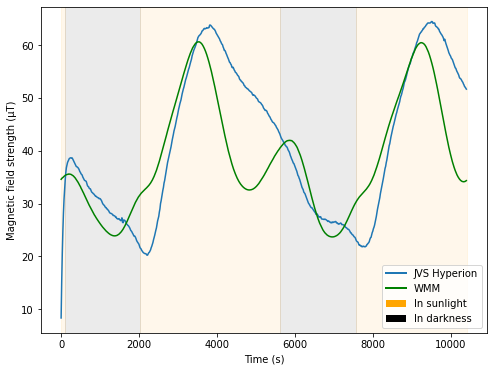

In [16]:
# Another combined plot with better day/night
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# 
magnetic_comparison['Time'] = magnetic_field_data['Time'] # Add time column to this df, eases work done later
plt.plot('Time', 'Magnitude', data=magnetic_field_data)
plt.plot('Time', 'WMM_Magnitude', data=magnetic_comparison, color='green')
plt.xlabel("Time (s)")
plt.ylabel("Magnetic field strength (\u03BCT)")
# Day/Night
plt.axvspan(0, 90, color='orange', alpha=0.08, zorder=-100)
plt.axvspan(90, 2025, color='black', alpha=0.08, zorder=-100)
plt.axvspan(2025, 5625, color='orange', alpha=0.08, zorder=-100)
plt.axvspan(5625, 7560, color='black', alpha=0.08, zorder=-100)
plt.axvspan(7560, 10410, color='orange', alpha=0.08, zorder=-100)
# Better legend
legend_elements = [Line2D([0], [0], color='tab:blue', linewidth=2, label="JVS Hyperion"),
                   Line2D([0], [0], color='green', linewidth=2, label="WMM"),
                   Patch(facecolor='orange', label='In sunlight'),
                   Patch(facecolor='black', label='In darkness')]
plt.legend(handles=legend_elements, loc='lower right')
# Savefig
figure = plt.gcf()
figure.set_size_inches(8, 6)
plt.savefig("results.png", dpi = 600)
# Thumbnail
plt.show()

In [15]:
# Numbers are the truth
print(["WMM = " + str(magnetic_comparison['Magnitude'].corr(magnetic_comparison['WMM_Magnitude'])), "Day/Night = " + str(magnetic_comparison['Magnitude'].corr(magnetic_field_data['Sunlight']))])

['WMM = 0.7764519048388587', 'Day/Night = 0.5720182204167632']


From both the graph and the numerical correlation data, we see that the biggest correlation has to be founded with the WMM. However, at certain timestamps, for example between $4000$ and $6000$ seconds, our measurements go straight down, while the WMM predicts a more 'bumpy ride'. From the correlation coefficients, we can, per definition, state nothing about causality, but yet it seems more likely that the difference in magnetic field strength between the day and night side, if at all, is very small.

Things to research further: both maximum and minimum values for our measurements were higher/lower than WMM (so bigger amplitude, not just shifted). Also, our 'graph' is shifter to the right compared to the WMM. Has this something to do with day/night difference?